# Figure 4

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import multiprocessing as mp
import re
import pickle
from itertools import product

sys.path.append('./utils/')
from odeAnalysisUtils import rdModel_nsKill,Simulate_AT_FixedThreshold,\
                            GenerateATComparisonPlot,GenerateParameterDic,\
                            ProfileTreatmentStrategies
import myUtils as utils

# Format plots
sns.set(style="white",
        font_scale=1.5,
        rc={'figure.figsize':(12,6)})

In [2]:
# Define the parameters
paramDic = {"rS":.027, "rR":.027, "cRS":1., "cSR":1.,"dD":1.5, 
            "k":1., "D":0, "theta":1, 'DMax':1.}
paramDic['dR'] = 0.2*paramDic['rR']
paramDic['dS'] = 0.2*paramDic['rS']
nTimePts = 100
intervalLength = 1

# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")

## a) Example simulations of the effect of cost in the absence of turnover

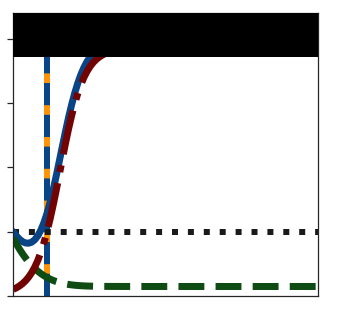

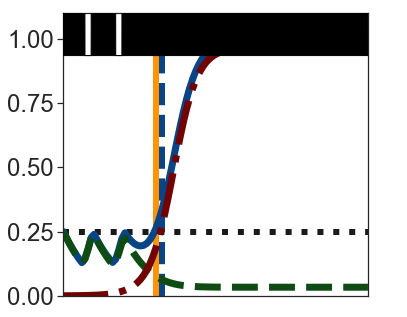

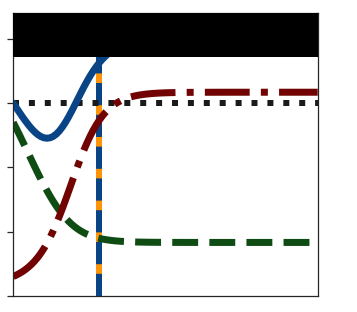

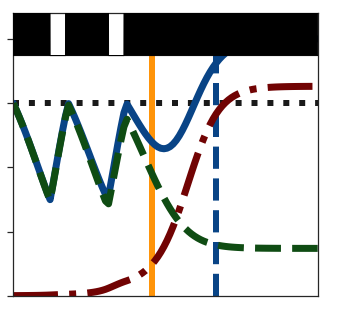

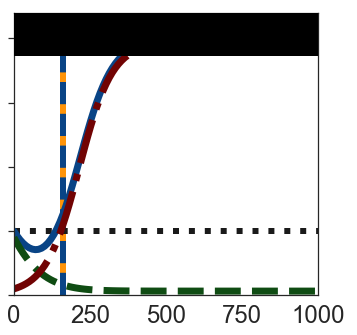

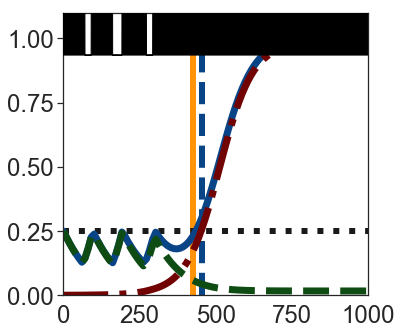

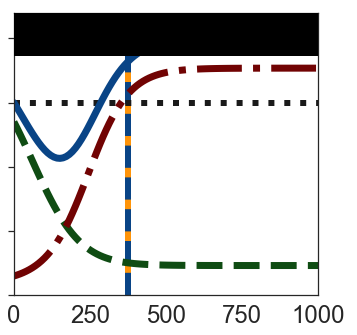

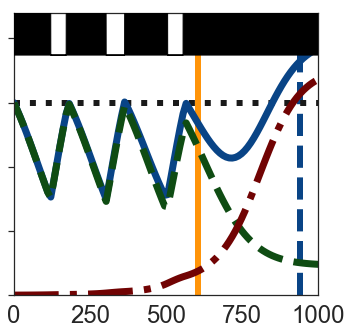

In [5]:
initialSizeList = [0.25, 0.75]
rFracList = [0.1, .001]
tEnd = 1000

for cost in [0,0.3]:
    for initialSize, rFrac in product(initialSizeList,rFracList):
        _,currParamDic = GenerateParameterDic(initialSize=0,rFrac=0, # Note: initial composition has no meaning here as it's set within the GenerateATComparisonPlot() function
                                              cost=cost,turnover=0,
                                              paramDic=paramDic)
        GenerateATComparisonPlot(initialTumourSize=initialSize,rFrac=rFrac,paramDic=currParamDic,
                                 relToPopEq=False,t_end=tEnd,ylim=1.1,figsize=(6,5),
                                 decorateX=cost==0.3,decorateY=initialSize==0.25 and rFrac==0.001,
                                 outName="figures/timeSeriesPlot_noTurnover_corners_cost_%1.2f_n0_%1.2f_fR_%1.2f.pdf"%(cost,initialSize,rFrac))

## b) TTP gained as function of cost in absence of turnover

In [19]:
initialSizeList = [0.25,.75]
rFracList = [0.1, .001]
costList = np.linspace(0,0.5,6)

def NameTumours(x):
    # Function to assign the names to the tumours as given in the paper
    if x['InitialTumourSize'] == 0.25:
        if x['RFrac'] == 0.1:
            return 1
        else:
            return 2
    else:
        if x['RFrac'] == 0.1:
            return 3
        else:
            return 4        

# Collect data
if True:
    # Run simulations
    tmpDfList = []
    for cost in costList:
        _,currParamDic = GenerateParameterDic(initialSize=0,rFrac=0,
                                              cost=cost,turnover=0,
                                              paramDic=paramDic)
        txComparisonDf = ProfileTreatmentStrategies(modelFun=rdModel_nsKill,paramDic=currParamDic,
                                                    atThresholdList=[0.5],intervalLength=intervalLength ,
                                                    initialSizeList=initialSizeList,
                                                    rFracList=rFracList,
                                                    tumourSizeWhenProgressed=1.2,cureThreshold=1e-7)
        txComparisonDf['Cost'] = cost
        tmpDfList.append(txComparisonDf)
    impactOfCostDf_noTurnover = pd.concat(tmpDfList)
    impactOfCostDf_noTurnover['RelTimeGained'] *= 100
    impactOfCostDf_noTurnover['Cost'] *= 100
    
    # Name each tumour
    impactOfCostDf_noTurnover['TumourId'] = impactOfCostDf_noTurnover.apply(NameTumours,axis=1)
    impactOfCostDf_noTurnover.to_csv("./data/ttpComparison/ttpComparison_cost_noTurnover.csv")

100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


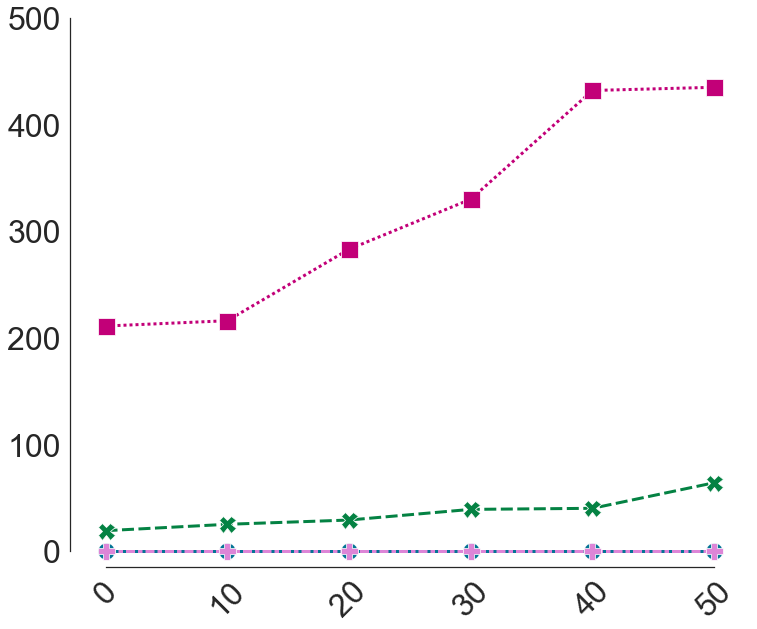

In [5]:
impactOfCostDf_noTurnover = pd.read_csv("./data/ttpComparison/ttpComparison_cost_noTurnover.csv",index_col=0)
# dataDf = impactOfCostDf_noTurnover[impactOfCostDf_noTurnover.TreatmentBranch=='0.5']

fig, axList = plt.subplots(1,1,figsize=(12,10))
currAx = axList
sns.lineplot(x='Cost',y='AbsTimeGained',
             style='TumourId',hue='TumourId',
             style_order=[1,2,4,3],
             palette=sns.xkcd_palette([ "sea blue", "jungle green", "lavender pink", "magenta"]),
             markers=True, lw=3, markersize=17,
             data=impactOfCostDf_noTurnover,ax=currAx)
currAx.set_ylim(-10,500)
currAx.set_xlabel("")
currAx.set_ylabel("")
currAx.tick_params(labelsize=32)
currAx.get_legend().remove()
sns.despine(offset=5, trim=True)
plt.xticks(rotation=45);
plt.savefig("figures/impactOfCost_noTurnover_timeGained.pdf")

## c) Competition Experiments

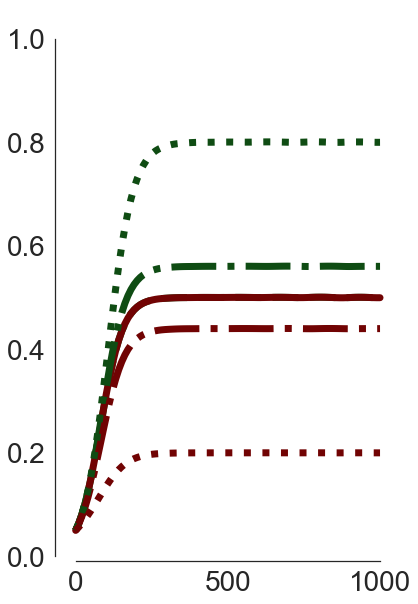

In [7]:
currParamDic = paramDic.copy()
currParamDic['dR'] = 0
currParamDic['dS'] = 0

PlotCompetitionExperiment(paramDic=currParamDic,figsize=(6,10),outName="figures/figure_coCulture_turnover_0.pdf")

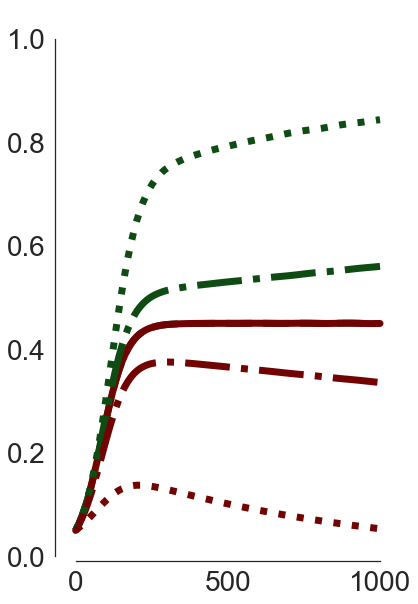

In [8]:
currParamDic = paramDic.copy()
currParamDic['dR'] = 0.1*currParamDic['rR']
currParamDic['dS'] = 0.1*currParamDic['rS']

PlotCompetitionExperiment(paramDic=currParamDic,figsize=(6,10),outName="figures/figure_coCulture_turnover_10.pdf")

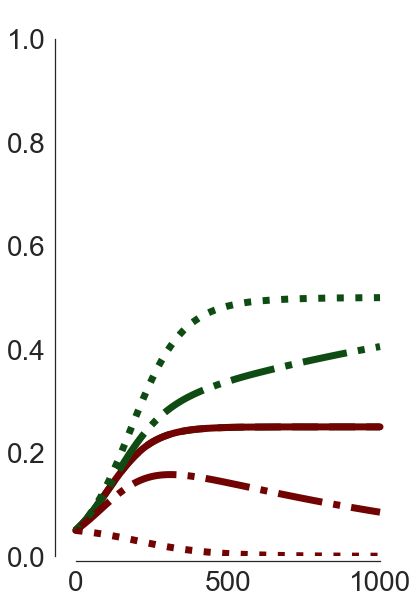

In [9]:
currParamDic = paramDic.copy()
currParamDic['dR'] = 0.5*currParamDic['rR']
currParamDic['dS'] = 0.5*currParamDic['rS']

PlotCompetitionExperiment(paramDic=currParamDic,figsize=(6,10),outName="figures/figure_coCulture_turnover_50.pdf")

## d) Cost-turnover landscape

In [8]:
txComparisonDf = pd.read_csv('./data/ttpComparison/ttpAnalysis_costTurnoverSweep.csv',index_col=0)

/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  
/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


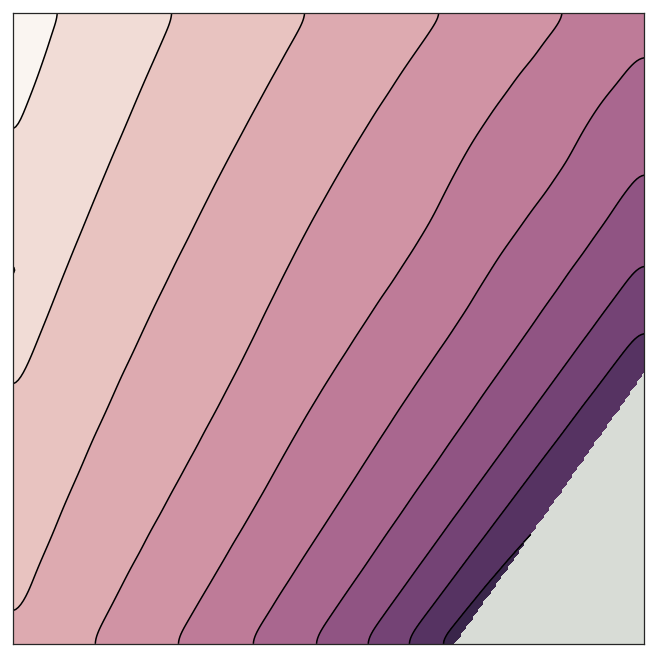

In [12]:
# Reshape into a matrix
tmpDf = txComparisonDf.loc[txComparisonDf.TreatmentBranch=="0.5",["Cost","Turnover","TimeGained"]].reset_index(drop=True)
tmpDf['Cost'] *= 100
tmpDf['Turnover'] *= 100
tmpDf['TimeGained'] = np.log10(tmpDf['TimeGained'])
tmpDf.sortlevel(["Cost"], ascending=[False], sort_remaining=False)
timeToFailureMat = tmpDf.pivot("Cost","Turnover","TimeGained")
# timeToFailureMat.sort_index(level="Cost",ascending=False,inplace=True)

# Smooth the data. The slight complication comes from the NAs. Remove their effect near the boundary by scaling it out.
from scipy.ndimage.filters import gaussian_filter
V=timeToFailureMat.copy()
V[np.isnan(timeToFailureMat)]=0
VV=gaussian_filter(V,sigma=4)

W=0*timeToFailureMat.copy()+1
W[np.isnan(timeToFailureMat)]=0
WW=gaussian_filter(W,sigma=4)

X=VV/WW
X[np.isnan(timeToFailureMat)] = np.nan
timeToFailureMat = X

# Plot
fig, ax = plt.subplots(1,1,figsize=(12,10))
ax.contourf(tmpDf.Cost.unique(),tmpDf.Turnover.unique(),timeToFailureMat,10,
            cmap=sns.cubehelix_palette(light=1, as_cmap=True))
contours = ax.contour(tmpDf.Cost.unique(),tmpDf.Turnover.unique(),timeToFailureMat, 10, colors='black');
plt.gca().set_facecolor('xkcd:light grey')
# plt.clabel(contours, inline=True, fontsize=28, fmt='%1.1f', rightside_up=True, )
# g = sns.heatmap(data=timeToFailureMat,cmap='viridis',square=True,cbar=False,ax=ax)



# n0 = 0.25
# x = np.linspace(0,50,10)
# ax.plot(x,100-x/(1-1.2*n0),'r',lw=7)

ax.tick_params(labelsize=32)
ax.set_ylim(0,50)
ax.invert_yaxis()
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(rotation=45)
plt.tight_layout()
plt.xticks([], [])
plt.yticks([], [])
plt.gca().set_aspect('equal', adjustable='box')
# plt.axis('off')
plt.savefig("figures/costTurnoverSweep.pdf")


In [13]:
np.log(txComparisonDf.TimeGained.max())

7.663919938117062

## e) Simulations accompanying the cost-turnover landscape plot

In [ ]:
for cost in [0,0.3]:
    for initialSize, rFrac in product(initialSizeList,rFracList):
        _,currParamDic = GenerateParameterDic(initialSize=0,rFrac=0, # Note: initial composition has no meaning here as it's set within the GenerateATComparisonPlot() function
                                              cost=cost,turnover=0,
                                              paramDic=paramDic)
        GenerateATComparisonPlot(initialTumourSize=initialSize,rFrac=rFrac,paramDic=currParamDic,
                                 relToPopEq=False,t_end=tEnd,ylim=1.1,figsize=(6,5),
                                 decorateX=cost==0.3,decorateY=initialSize==0.25 and rFrac==0.001,
                                 outName="figures/timeSeriesPlot_noTurnover_corners_cost_%1.2f_n0_%1.2f_fR_%1.2f.pdf"%(cost,initialSize,rFrac))

TTP_CT: 303.03; TTP_AT: 323.23
Relative gain: 6.67%; Absolute Gain: 20.20d
TTP_CT: 616.16; TTP_AT: 848.48
Relative gain: 37.70%; Absolute Gain: 232.32d
TTP_CT: 575.76; TTP_AT: 646.46
Relative gain: 12.28%; Absolute Gain: 70.71d
TTP_CT: nan; TTP_AT: nan
Relative gain: nan%; Absolute Gain: nand


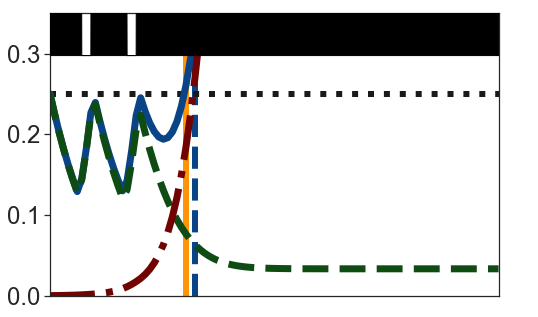

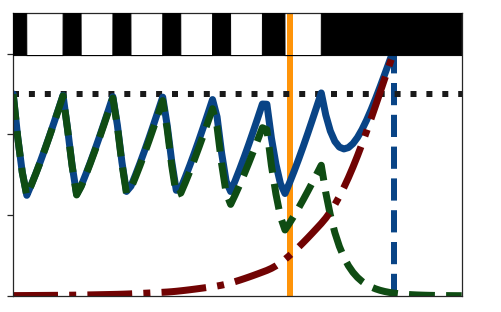

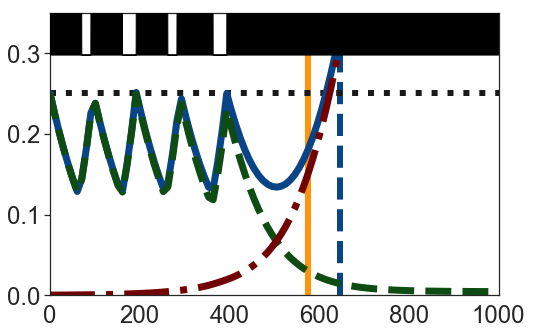

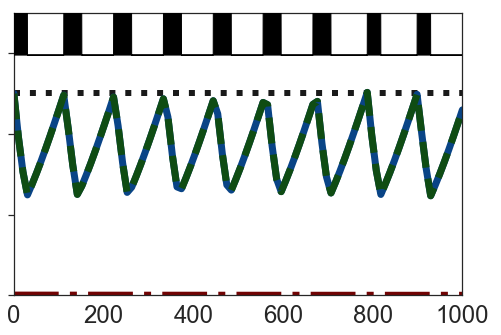

In [4]:
costList = [0,0.5]
turnoverList = [0,0.5]
for cost,turnover in product(costList,turnoverList):
    _,currParamDic = GenerateParameterDic(initialSize=0,rFrac=0, # Note: initial composition has no meaning here as it's set within the GenerateATComparisonPlot() function
                                          cost=cost,turnover=turnover,
                                          paramDic=paramDic)
    GenerateATComparisonPlot(initialTumourSize=0.25,rFrac=.001,paramDic=currParamDic,
                             t_end=1e3,ylim=0.35,#nTimePts=250,
                             decorateX=cost==0.5,decorateY=turnover==0,
                             printDifferenceInTTP=True,
                             outName="figures/impactOfCostOnAT_simulations_cost_%1.2f_turnover_%1.2f.pdf"%(cost,turnover))

## f) TTP gained as function of cost in presence of turnover

In [5]:
initialSizeList = [0.25,.5]
rFracList = [0.1, .001]
costList = np.linspace(0,0.5,6)

def NameTumours(x):
    # Function to assign the names to the tumours as given in the paper
    if x['InitialTumourSize'] == 0.25:
        if x['RFrac'] == 0.1:
            return 1
        else:
            return 2
    else:
        if x['RFrac'] == 0.1:
            return 3
        else:
            return 4        

# Collect data
if True:
    # Run simulations
    tmpDfList = []
    for cost in costList:
        _,currParamDic = GenerateParameterDic(initialSize=0,rFrac=0,
                                              cost=cost,turnover=0.25,
                                              paramDic=paramDic)
        txComparisonDf = ProfileTreatmentStrategies(modelFun=rdModel_nsKill,paramDic=currParamDic,
                                                    atThresholdList=[0.5],intervalLength=intervalLength ,
                                                    initialSizeList=initialSizeList,
                                                    rFracList=rFracList,
                                                    tumourSizeWhenProgressed=1.2,cureThreshold=1e-7)
        txComparisonDf['Cost'] = cost
        tmpDfList.append(txComparisonDf)
    impactOfCostDf_withTurnover = pd.concat(tmpDfList)
    impactOfCostDf_withTurnover['RelTimeGained'] *= 100
    impactOfCostDf_withTurnover['Cost'] *= 100
    
    # Name each tumour
    impactOfCostDf_withTurnover['TumourId'] = impactOfCostDf_withTurnover.apply(NameTumours,axis=1)
    impactOfCostDf_withTurnover.to_csv("./data/ttpComparison/ttpComparison_cost_withTurnover.csv")

100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


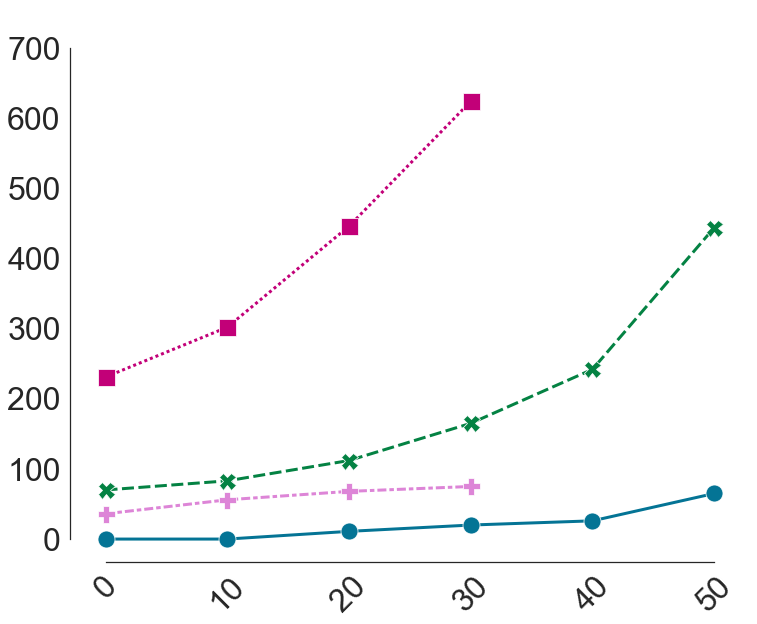

In [7]:
impactOfCostDf_withTurnover = pd.read_csv("./data/ttpComparison/ttpComparison_cost_withTurnover.csv",index_col=0)
# dataDf = impactOfCostDf_withTurnover[impactOfCostDf_withTurnover.TreatmentBranch=='0.5']

fig, axList = plt.subplots(1,1,figsize=(12,10))
currAx = axList
sns.lineplot(x='Cost',y='AbsTimeGained',
             style='TumourId',hue='TumourId',
             style_order=[1,2,4,3],
             palette=sns.xkcd_palette([ "sea blue", "jungle green", "lavender pink", "magenta"]),
             markers=True, lw=3, markersize=17,
             data=impactOfCostDf_withTurnover,ax=currAx)
currAx.set_ylim(-25,750)
currAx.set_xlabel("")
currAx.set_ylabel("")
currAx.tick_params(labelsize=32)
currAx.get_legend().remove()
sns.despine(offset=5, trim=True)
plt.xticks(rotation=45);
plt.savefig("figures/impactOfCost_withTurnover_timeGained.pdf")